## Compare encoded jpg image and dicom ground-truth

In [1]:
import os
import json
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from random import randint
import cv2
import itertools
from tqdm import tqdm
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = "/media/daitran/Data/Kaggle/VinBigData"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
TRAIN_CSV_DIR = os.path.join(DATA_DIR, "train.csv")
SS_CSV_DIR = os.path.join(DATA_DIR, "sample_submission.csv")

PREPROCESSED_TRAINING_IMAGE_FOLDER = '/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/'

In [3]:
orin_df = pd.read_csv(TRAIN_CSV_DIR)
orin_df = orin_df.query('class_id != 14')

### Helper functions for converting bounding boxes to the right format for Mask RCNN

In [4]:
def get_mask(img_dimensions, x_min, y_min, x_max, y_max):
    img_height, img_width = img_dimensions
    img_mask = np.full((img_height,img_width),0)
    img_mask[y_min:y_max,x_min:x_max] = 255
    return img_mask.astype(np.float32)
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 255)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

### Function convert DICOM data to np.array


In [5]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data


### Load data

#### Load img and encoded label data

In [6]:
training_df = pd.read_csv('/home/daitran/Desktop/git/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/1024_encoded_maskrcnn.csv', converters ={'EncodedPixels': eval, 'CategoryId': eval})

In [7]:
samples_df = training_df

In [8]:
samples_df

,image_id,CategoryId,EncodedPixels,Height,Width
0,9a5094b2563a1ef3ff50dc5c7ff71345,"[3, 10, 11, 3, 3, 0]",[348764 199 349788 199 350812 199 351836 199 3...,1024,1024
1,051132a778e61a86eb147c7c6f564dfe,"[0, 0, 3, 3, 11, 0, 3]",[575753 98 576777 98 577801 98 578825 98 57984...,1024,1024
2,1c32170b4af4ce1a3030eb8167753b06,"[11, 13, 11, 13, 13, 13, 11, 13, 13]",[259192 25 260216 25 261240 25 262264 25 26328...,1024,1024
3,0c7a38f293d5f5e4846aa4ca6db4daf1,"[5, 5, 8, 5, 9]",[618595 771 619619 771 620643 771 621667 771 6...,1024,1024
4,47ed17dcb2cbeec15182ed335a8b5a9e,"[8, 9, 8, 9, 9, 8, 7, 7]",[228047 40 229071 40 230095 40 231119 40 23214...,1024,1024
...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,"[0, 10, 13, 6, 4, 13, 10, 10]",[512275 138 513299 138 514323 138 515347 138 5...,1024,1024
36092,26d1d5a0ef2e692c6340e74859ffdc53,"[8, 10, 10, 13, 9, 11, 13, 9, 13, 11, 0, 8, 13...",[469130 24 470154 24 471178 24 472202 24 47322...,1024,1024
36093,22672ab82c290c20b86863291e25ef6c,"[5, 11, 10, 9, 10, 9, 11, 5, 13, 13, 11, 13, 1...",[153799 421 154823 421 155847 421 156871 421 1...,1024,1024
36094,db169d0be36123bd55b866d6aa73983b,"[10, 9, 9, 9, 0, 11, 7, 0, 9, 9, 13, 9, 9, 9, 9]",[21097 98 22121 98 23145 98 24169 98 25193 98 ...,1024,1024


## Implement Mask RCNN

In [9]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [10]:
NUM_CATS = 14
IMAGE_SIZE = 1024

In [11]:
class DiagnosticConfig(Config):
    NAME = "Diagnostic"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class

    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 #That is the maximum with the memory available on kernels

    BACKBONE = 'resnet50'

    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE
    IMAGE_RESIZE_MODE = 'none'

    POST_NMS_ROIS_TRAINING = 250
    POST_NMS_ROIS_INFERENCE = 150
    MAX_GROUNDTRUTH_INSTANCES = 5
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    BACKBONESHAPE = (8, 16, 24, 32, 48)
    RPN_ANCHOR_SCALES = (8,16,24,32,48)
    ROI_POSITIVE_RATIO = 0.33
    DETECTION_MAX_INSTANCES = 300
    DETECTION_MIN_CONFIDENCE = 0.7
    # STEPS_PER_EPOCH should be the number of instances
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = int(len(samples_df)*0.9/IMAGES_PER_GPU)
    VALIDATION_STEPS = len(samples_df)-int(len(samples_df)*0.9/IMAGES_PER_GPU)

config = DiagnosticConfig()
# config.display()

In [18]:
category_list = ["Aortic enlargement", "Atelectasis","Calcification","Cardiomegaly","Consolidation","ILD",
                "Infiltration", "Lung opacity", "Nodule/ Mass","Other lesion","Pleural effusion",
                "Pleural thickening", "Pneumothorax","Pulmonary fibrosis"]
category_list

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung opacity',
 'Nodule/ Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [19]:
class DiagnosticDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)

        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("diagnostic", i+1, name)

        # Add images
        for i, row in df.iterrows():
            self.add_image("diagnostic",
                           image_id=row.name,
                           path= PREPROCESSED_TRAINING_IMAGE_FOLDER+str(row.image_id)+".png",
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'],
                           height=row['Height'], width=row['Width'],
                           img_org_id = row.image_id)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]

    def load_image(self, image_id):

        return cv2.imread(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]

        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)

            annotation = [int(x) for x in annotation.split(' ')]

            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
        return mask, np.array(labels)

## Train/ Val/ Test Split

In [20]:
# Split with train = 80% samples and val = 10% and test = 10%
training_percentage = 0.8

training_set_size = int(training_percentage*len(samples_df))
validation_set_size = int((0.9-training_percentage)*len(samples_df))
test_set_size = int((0.9-training_percentage)*len(samples_df))

train_dataset = DiagnosticDataset(samples_df[:training_set_size])
train_dataset.prepare()

valid_dataset = DiagnosticDataset(samples_df[training_set_size:training_set_size+validation_set_size])
valid_dataset.prepare()

test_dataset = DiagnosticDataset(samples_df[training_set_size + validation_set_size:])
test_dataset.prepare()

### Inspect train /val /test set

In [21]:
print('Samples of train = {}; val = {}, test = {}'.format(len(train_dataset.image_ids), len(valid_dataset.image_ids), len(test_dataset.image_ids)))

Samples of train = 28876; val = 3609, test = 3611


In [22]:
def plot_bbox(img_id , bbox_df = orin_df, normalize = True):

    img_ids = bbox_df['image_id'].values
    class_ids = bbox_df['class_id'].unique()

    label2color = {class_id:[randint(0,255) for i in range(3)] for class_id in class_ids}

    plt.figure(figsize=(20,8))
    sub_num =1

    img_id = img_id

    img_path = os.path.join(TRAIN_DIR, img_id + ".dicom")
    img = dicom2array(img_path)

    if normalize:
        # normalize
        img = exposure.equalize_adapthist(img/np.max(img))
        img = (img * 255).astype(np.uint8)

    # convert from single-channel grayscale to 3-channel RGB
    img = np.stack([img] * 3, axis=2)

    # add bounding boxes
    box_coordinates = bbox_df.loc[bbox_df['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values
    labels = bbox_df.loc[bbox_df['image_id'] == img_id, ['class_id']].values.squeeze()
    if not labels.shape:
        labels = np.expand_dims(labels, axis =0)

    for label_id, box in zip(labels, box_coordinates):
        color = label2color[label_id]
        img_bbox = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color = color, thickness= 8
        )
        # add labels
        cv2.putText(img_bbox, str(label_id), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 5, (36,255,12), 5)

    plt.subplot(1,3,sub_num)
    sub_num += 1
    plt.imshow(img_bbox, cmap = 'gray')
    plt.title('Finding contains in image')

    plt.show()

## Inspect bounding boxes

/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/47d1e25eede8a23cc44fda5c031127d6.png


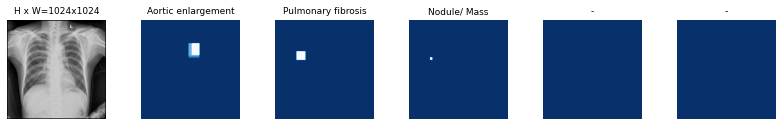

image_id  463 ('/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/47d1e25eede8a23cc44fda5c031127d6.png', ['Pulmonary fibrosis', 'Aortic enlargement', 'Aortic enlargement', 'Aortic enlargement', 'Nodule/ Mass'])
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 5)       min:    0.00000  max:    1.00000  uint8
class_ids                shape: (5,)                  min:    1.00000  max:   14.00000  int64
bbox                     shape: (5, 4)                min:  217.00000  max:  606.00000  int32


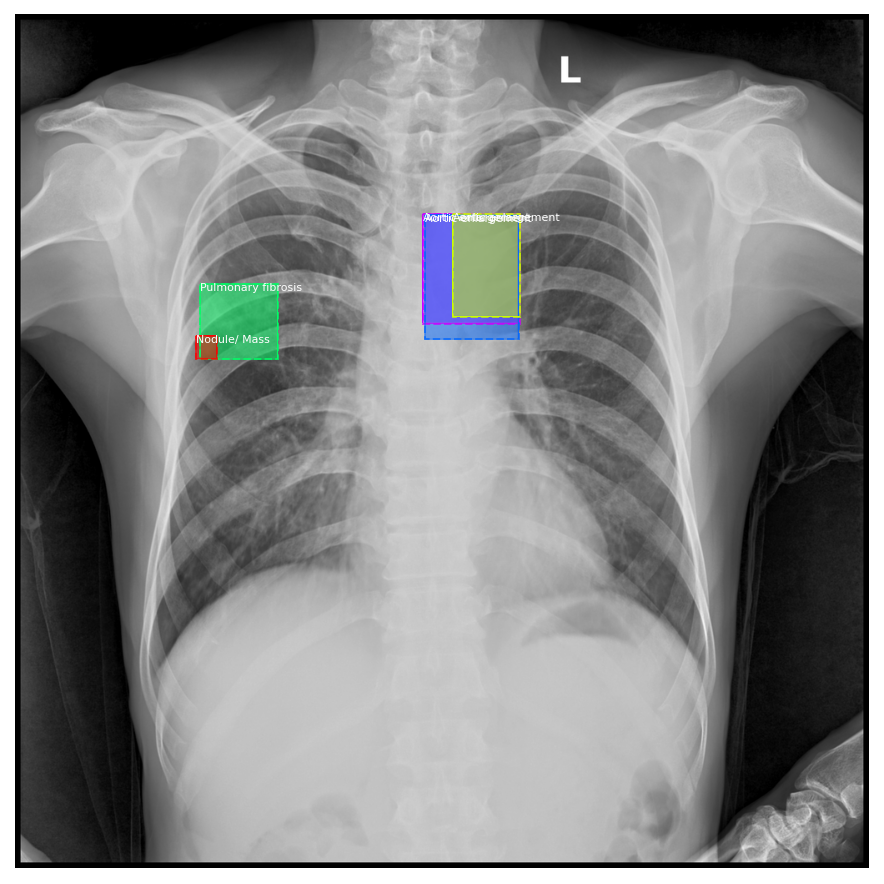

/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/bd24133a5c72fdd62ad820445627b718.png


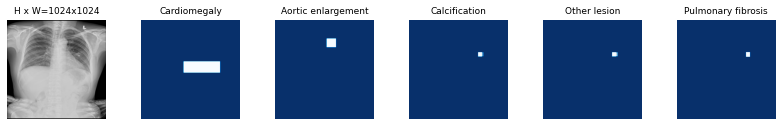

image_id  375 ('/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/bd24133a5c72fdd62ad820445627b718.png', ['Cardiomegaly', 'Calcification', 'Calcification', 'Pulmonary fibrosis', 'Other lesion', 'Calcification', 'Aortic enlargement', 'Other lesion'])
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 8)       min:    0.00000  max:    1.00000  uint8
class_ids                shape: (8,)                  min:    1.00000  max:   14.00000  int64
bbox                     shape: (8, 4)                min:  191.00000  max:  818.00000  int32


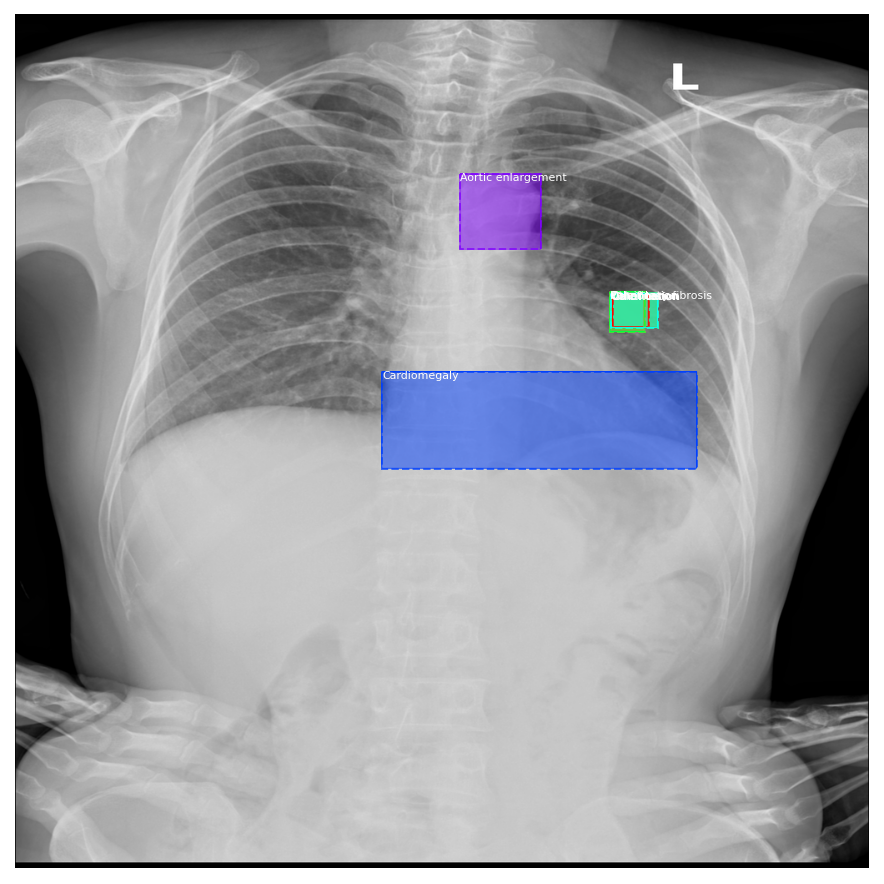

/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/50f315c754b3530ac3c9bac3e96b22ac.png


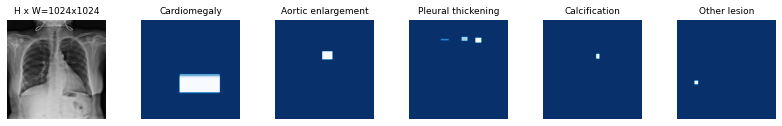

image_id  2914 ('/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/50f315c754b3530ac3c9bac3e96b22ac.png', ['Cardiomegaly', 'Other lesion', 'Pleural thickening', 'Pleural thickening', 'Cardiomegaly', 'Calcification', 'Cardiomegaly', 'Pleural thickening', 'Aortic enlargement', 'Calcification'])
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
mask                     shape: (1024, 1024, 10)      min:    0.00000  max:    1.00000  uint8
class_ids                shape: (10,)                 min:    1.00000  max:   12.00000  int64
bbox                     shape: (10, 4)               min:  174.00000  max:  818.00000  int32


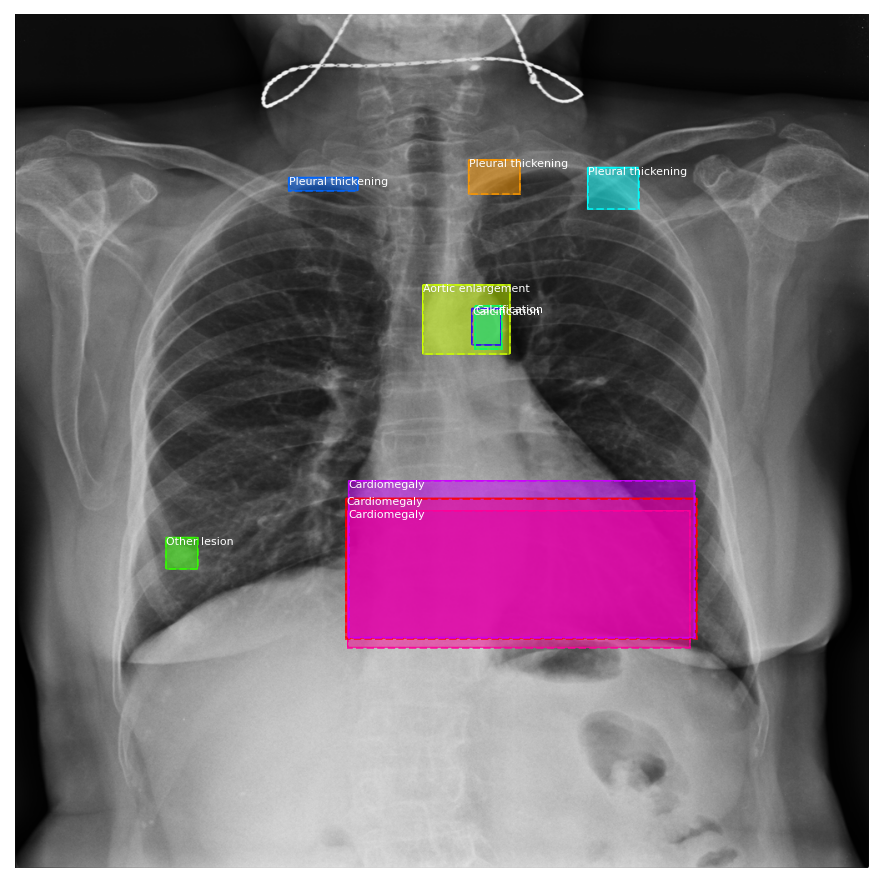

/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/db169d0be36123bd55b866d6aa73983b.png


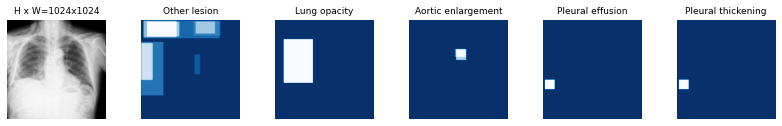

image_id  3609 ('/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/db169d0be36123bd55b866d6aa73983b.png', ['Pleural effusion', 'Other lesion', 'Other lesion', 'Other lesion', 'Aortic enlargement', 'Pleural thickening', 'Lung opacity', 'Aortic enlargement', 'Other lesion', 'Other lesion', 'Pulmonary fibrosis', 'Other lesion', 'Other lesion', 'Other lesion', 'Other lesion'])
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.00000  uint8
mask                     shape: (1024, 1024, 15)      min:    0.00000  max:    1.00000  uint8
class_ids                shape: (15,)                 min:    1.00000  max:   14.00000  int64
bbox                     shape: (15, 4)               min:    1.00000  max:  878.00000  int32


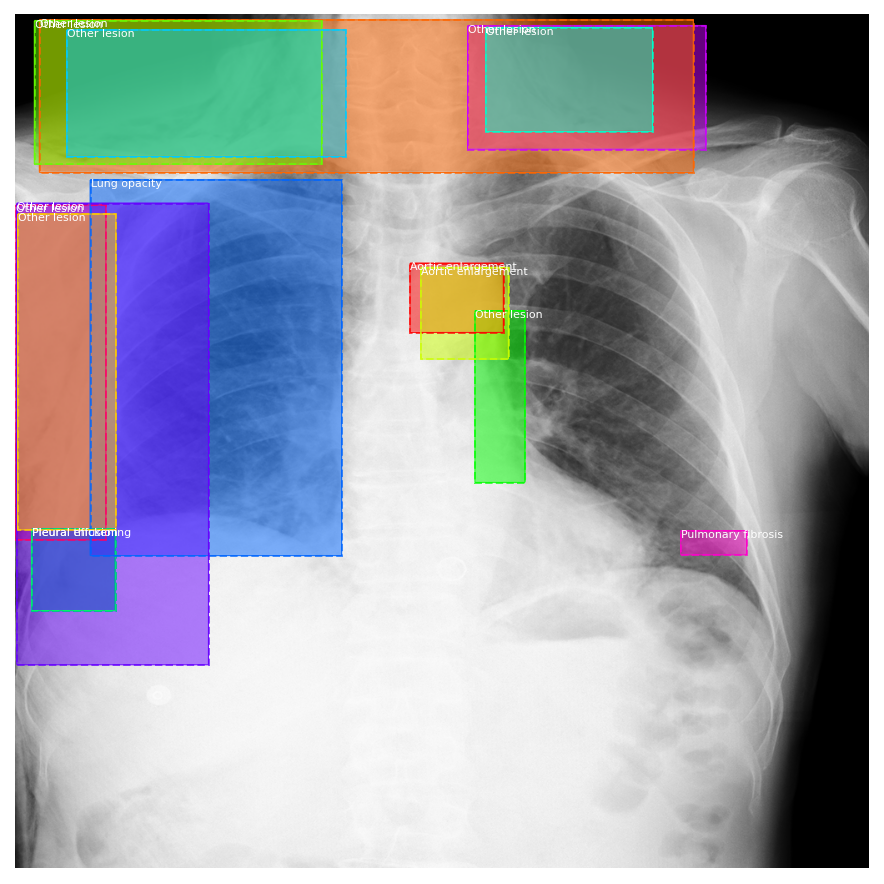

/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/56e12dd250d23cb2199f1f90eb5a337f.png


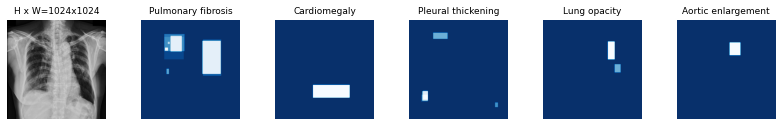

image_id  3094 ('/home/daitran/Desktop/research/kaggle/VinBigData/preprocessed_data/1024_wh/train/56e12dd250d23cb2199f1f90eb5a337f.png', ['Pleural thickening', 'Pleural thickening', 'Pulmonary fibrosis', 'Pleural effusion', 'Pulmonary fibrosis', 'Pulmonary fibrosis', 'Cardiomegaly', 'Lung opacity', 'Pulmonary fibrosis', 'Pulmonary fibrosis', 'Pleural thickening', 'Pleural effusion', 'Aortic enlargement', 'Nodule/ Mass', 'Pulmonary fibrosis', 'Pleural thickening', 'Lung opacity', 'Pulmonary fibrosis', 'Pleural thickening', 'Pulmonary fibrosis', 'Nodule/ Mass'])
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  245.00000  uint8
mask                     shape: (1024, 1024, 21)      min:    0.00000  max:    1.00000  uint8
class_ids                shape: (21,)                 min:    1.00000  max:   14.00000  int64
bbox                     shape: (21, 4)               min:  126.00000  max:  920.00000  int32


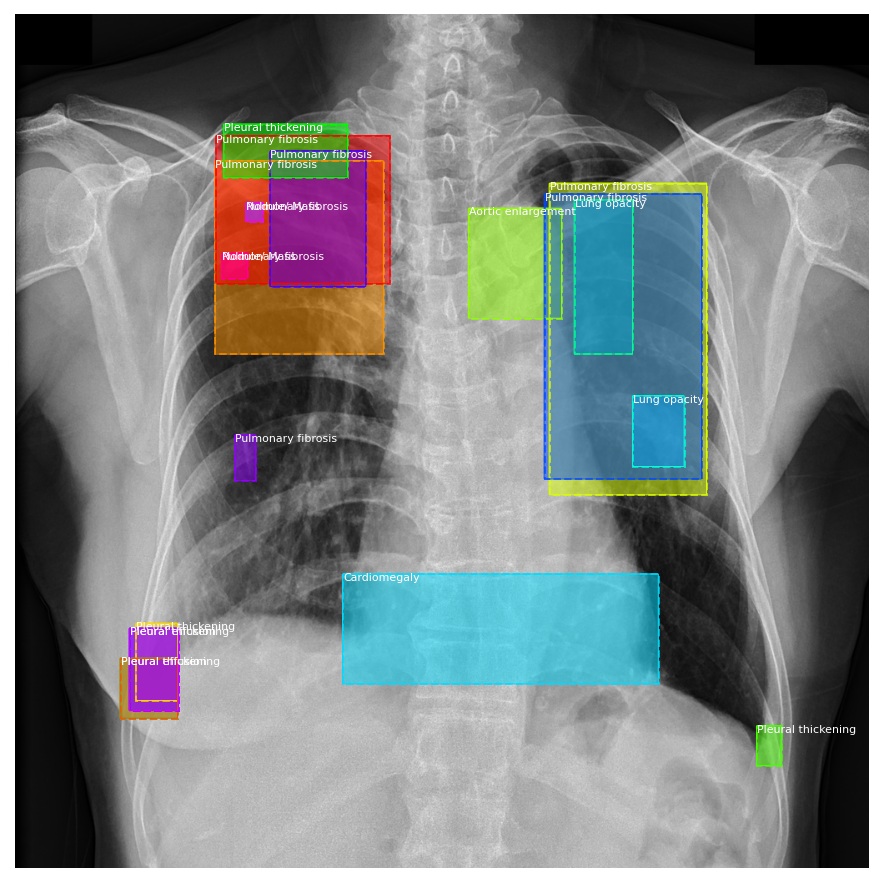

In [23]:
for i in range(0,5):
    image_jpg_id = random.choice(test_dataset.image_ids)
    print(test_dataset.image_info[image_jpg_id]['path'])
    
    image = test_dataset.load_image(image_jpg_id)
    mask, class_ids = test_dataset.load_mask(image_jpg_id)
    
    visualize.display_top_masks(image, mask, class_ids, test_dataset.class_names, limit=5)
    
    # Compute Bounding box
    bbox = utils.extract_bboxes(mask)
    
    # Display image and additional stats
    print("image_id ", image_jpg_id, test_dataset.image_reference(image_jpg_id))
    log("image", image)
    log("mask", mask)
    log("class_ids", class_ids)
    log("bbox", bbox)
    # Display image and instances
    visualize.display_instances(image, bbox, mask, class_ids, test_dataset.class_names)
    
    
    
    
#     print(train_dataset.image_info[image_jpg_id]['img_org_id'])
#     plot_bbox(img_id = test_dataset.image_info[image_jpg_id]['img_org_id'])